# 7주차 1D Adjoint Optimization 수정 

#### 보완사항
##### 1. PML , design region 겹치지 않게
##### 2. Power 측정을 위해 design region 바깥 쪽으로 이동 


In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt


seed = 240
np.random.seed(seed)
Air = mp.Medium(index=1)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

In [2]:
resolution = 20

Sx = 6
Sy = 8
cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(1)]

In [3]:
fcen = 1 / 1.55
width = 0.1
fwidth = width * fcen
source_center = [0, 3, 0]
source_size = mp.Vector3(6, 0, 0) #source size > wave guide 폭  
kpoint = mp.Vector3(0, -1, 0)
source = [
    mp.EigenModeSource(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

In [4]:
Ny = 20

design_variables = mp.MaterialGrid(mp.Vector3(0, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables, volume=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(2, 3, 0))
)

geometry = [
    mp.Block(center=mp.Vector3(), material=Si, size=mp.Vector3(2, 8, 0)),
    mp.Block(center=design_region.center, 
                     size=design_region.size, 
                     material=design_variables),  # design region
    # mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
    #        e1=mp.Vector3(x=-1).rotate(mp.Vector3(z=1), np.pi/2), e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), np.pi/2))
    #
    # The commented lines above impose symmetry by overlapping design region with the same design variable. However,
    # currently there is an issue of doing that; We give an alternative approach to impose symmetry in later tutorials.
    # See https://github.com/NanoComp/meep/issues/1984 and https://github.com/NanoComp/meep/issues/2093
]

In [5]:
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
)

In [6]:
TE0 = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(0, -3, 0), size=mp.Vector3(x=2)), mode=1
)
ob_list = [TE0]

In [7]:
'''
objective function은 해당 objective quantity의 절대값의 제곱으로 정의
'''

def J(alpha):
    return npa.abs(alpha) ** 2

In [8]:
'''
OptimizationProblem을 정의
'''

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=design_region,
    fcen=fcen,
    df=0,
    nf=1,
    decay_by=1e-2 #field decay to stop simulation?
)

In [9]:
x0 = np.random.rand(Ny) # 초기 추정치를 설정하기 위해 design parameter를 무작위한 값으로 설정한다.
opt.update_design([x0])

     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:519: UserWarning: The frequency parameter of plot2D has been deprecated. Use the frequency key of the eps_parameters dictionary instead.
  warnings.warn(


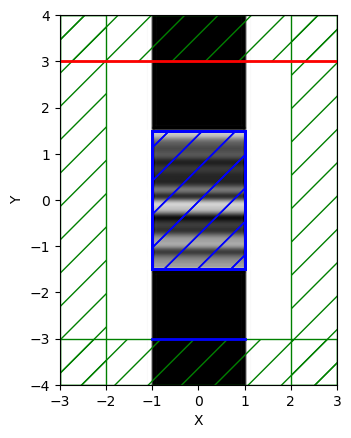

In [10]:
opt.plot2D(True, frequency=1 / 1.55)
plt.show()

In [11]:
f0, dJ_du = opt()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000126123 s
Working in 2D dimensions.
Computational cell is 6 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0105889 s
-----------
MPB solved for frequency_1(0,-1,0) = 0.30066 after 61 iters
MPB solved for frequency_1(0,-2.19008,0) = 0.647662 after 15 iters
MPB solved for frequency_1(0,-2.18154,0) = 0.645161 after 10 iters
MPB solved for frequency_1(0,-2.18154,0) = 0.645161 after 1 iters
run 0 finished at t = 155.925 (6237 timesteps)
MPB solved for frequency_1(0,0.645161,0) = 0.189753 after 22 iters
MPB solved for frequency_1(0,2.19355,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,2.193548,0.000000)
Starting adjoi

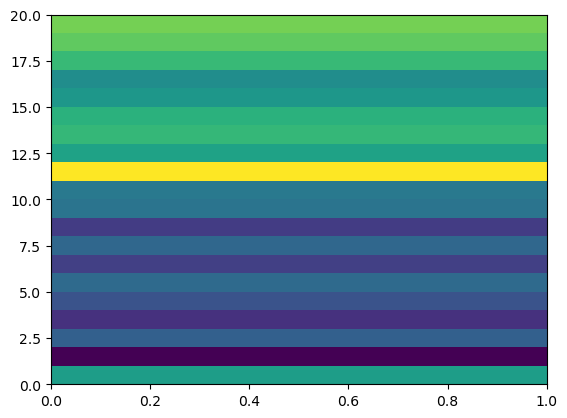

In [12]:
plt.figure()
plt.imshow(np.rot90(dJ_du.reshape(1,Ny)), origin='lower', extent=[0, 1, 0, Ny], aspect='auto')


In [13]:
'''
Inverse Design이 제대로 되었는지를 확인하기 위해 finite difference approximation을 수행한다.
'''


db = 1e-3
choose = 10
# resolution = 30 
# opt.sim.resolution = resolution
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000122786 s
Working in 2D dimensions.
Computational cell is 6 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0106339 s
-----------
MPB solved for frequency_1(0,-1,0) = 0.30066 after 61 iters
MPB solved for frequency_1(0,-2.19008,0) = 0.647662 after 15 iters
MPB solved for frequency_1(0,-2.18154,0) = 0.645161 after 10 iters
MPB solved for frequency_1(0,-2.18154,0) = 0.645161 after 1 iters
run 2 finished at t = 156.425 (6257 timesteps)
MPB solved for frequency_1(0,0.645161,0) = 0.189753 after 22 iters
MPB solved for frequency_1(0,2.19355,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,2.193548,0.000000)
-----------
Initializing structure...


In [14]:
'''
Adjoint optimization의 결과와 Finite difference approximation의 결과를 선형회귀를 통해 비교한다.
'''

(m, b) = np.polyfit(dJ_du[idx], np.squeeze(g_discrete),1)

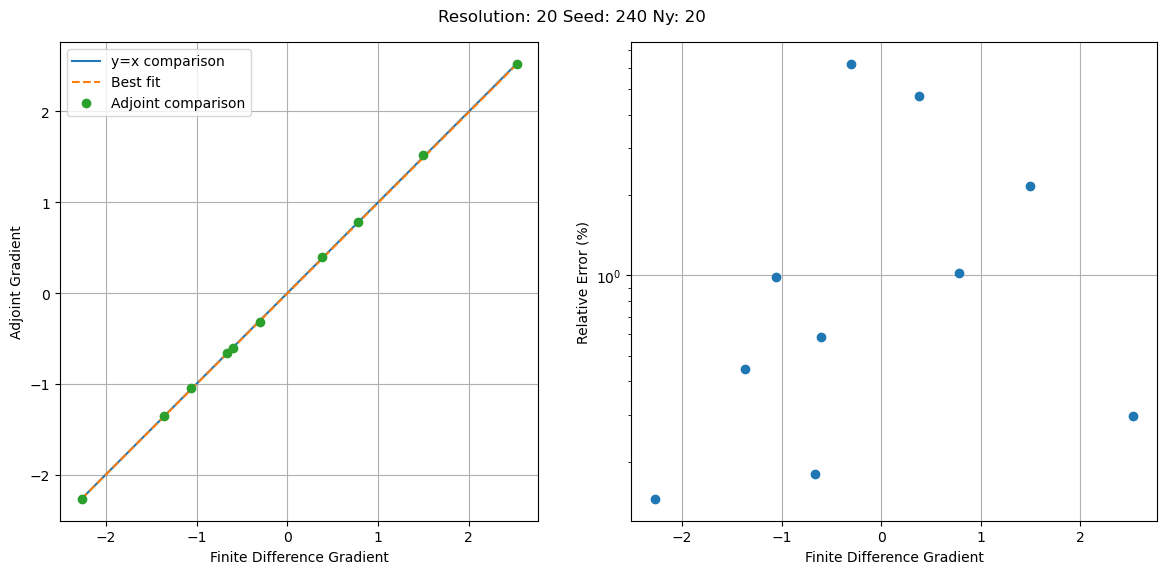

In [15]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Ny: {}".format(resolution, seed, Ny))
plt.show()

     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)


(-3.0, 3.0, -4.0, 4.0)

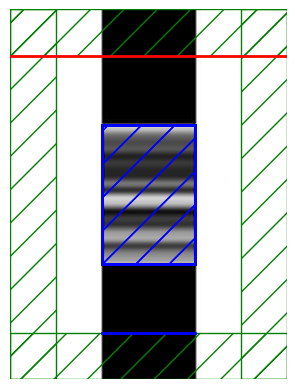

In [16]:
opt.update_design([x0])
opt.plot2D(True,
           plot_monitors_flag = True,
           output_plane = mp.Volume(center=mp.Vector3(0, 0, 0), size=mp.Vector3(6,8)),
)

plt.axis("off")

     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)


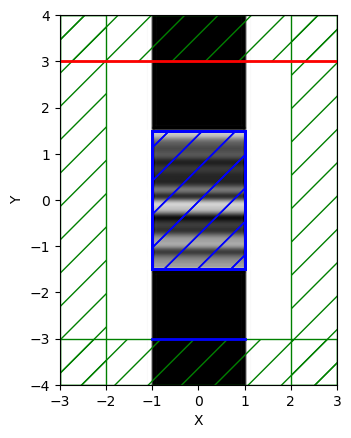

-----------
Initializing structure...
time for choose_chunkdivision = 0.000116825 s
Working in 2D dimensions.
Computational cell is 6 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.010509 s
-----------
MPB solved for frequency_1(0,-1,0) = 0.30066 after 61 iters
MPB solved for frequency_1(0,-2.19008,0) = 0.647662 after 15 iters
MPB solved for frequency_1(0,-2.18154,0) = 0.645161 after 10 iters
MPB solved for frequency_1(0,-2.18154,0) = 0.645161 after 1 iters


FloatProgress(value=0.0, description='0% done ', max=25.0)

creating output file "./ez-000000.10.h5"...
creating output file "./ez-000000.20.h5"...
creating output file "./ez-000000.30.h5"...
creating output file "./ez-000000.40.h5"...
creating output file "./ez-000000.50.h5"...
creating output file "./ez-000000.60.h5"...
creating output file "./ez-000000.70.h5"...
creating output file "./ez-000000.80.h5"...
creating output file "./ez-000000.90.h5"...
creating output file "./ez-000001.00.h5"...
creating output file "./ez-000001.10.h5"...
creating output file "./ez-000001.20.h5"...
creating output file "./ez-000001.30.h5"...
creating output file "./ez-000001.40.h5"...
creating output file "./ez-000001.50.h5"...
creating output file "./ez-000001.60.h5"...
creating output file "./ez-000001.70.h5"...
creating output file "./ez-000001.80.h5"...
creating output file "./ez-000001.90.h5"...
creating output file "./ez-000002.00.h5"...
creating output file "./ez-000002.10.h5"...
creating output file "./ez-000002.20.h5"...
creating output file "./ez-00000

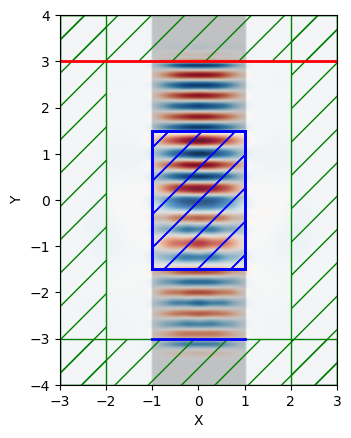

In [17]:
opt.prepare_forward_run()
src = mp.ContinuousSource(frequency=fcen, end_time = 25)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]
opt.sim.change_sources(source)
opt.plot2D()
plt.show()

opt.sim.run(mp.at_every(0.1, mp.output_png(mp.Ez, "-Zc dkbluered ")), until = 25)
opt.sim.plot2D(fields = mp.Ez)
plt.show()


In [18]:
'''
Make a GIF file from the output images and play in the notebook
'''
from IPython.display import Image, display
import imageio
import os

# Set the directory where the output images are saved
output_dir = "/root/"

# Get the list of image files in the directory
image_files = sorted([os.path.join(output_dir, file) for file in os.listdir(output_dir) if file.endswith(".png")])

# Create the GIF file
output_gif = "output.gif"
with imageio.get_writer(output_gif, mode="I") as writer:
    for image_file in image_files:
        image = imageio.imread(image_file)
        writer.append_data(image)

print("GIF file created: {}".format(output_gif))

gif_path = "output.gif"

# Display the GIF file
display(Image(filename=gif_path))


PermissionError: [Errno 13] Permission denied: '/root/'